In [1]:
import sys

sys.path.append("../..")

import gymnasium as gym
from miniworld.params import DEFAULT_PARAMS
from fourier_scaffold import (
    FourierScaffold,
    HadamardShiftMatrixRat,
    GuassianFourierSmoothingMatrix,
)
from fourier_vectorhash import FourierVectorHaSH, FourierVectorHaSHAgent, path_test
import copy
import numpy as np

import math
import torch
from preprocessing_cnn import (
    GrayscaleAndFlattenPreprocessing,
    RescalePreprocessing,
    SequentialPreprocessing,
)
from hippocampal_sensory_layers import (
    ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars,
    ComplexExactPseudoInverseHippocampalSensoryLayer,
)

### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    # [
    #     "MiniWorld-CollectHealth-v0",
    #     "MiniWorld-FourRooms-v0",
    #     "MiniWorld-Hallway-v0",
    #     "MiniWorld-Maze-v0",
    #     "MiniWorld-MazeS2-v0",
    #     "MiniWorld-MazeS3-v0",
    #     "MiniWorld-MazeS3Fast-v0",
    #     "MiniWorld-OneRoom-v0",
    #     "MiniWorld-OneRoomS6-v0",
    #     "MiniWorld-OneRoomS6Fast-v0",
    #     "MiniWorld-PickupObjects-v0",
    #     "MiniWorld-PutNext-v0",
    #     "MiniWorld-RoomObjects-v0",
    #     "MiniWorld-Sidewalk-v0",
    #     "MiniWorld-Sign-v0",
    #     "MiniWorld-TMaze-v0",
    #     "MiniWorld-TMazeLeft-v0",
    #     "MiniWorld-TMazeRight-v0",
    #     "MiniWorld-ThreeRooms-v0",
    #     "MiniWorld-WallGap-v0",
    #     "MiniWorld-YMaze-v0",
    #     "MiniWorld-YMazeLeft-v0",
    #     "MiniWorld-YMazeRight-v0",
    # ]
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
print(env.observation_space)

shapes = [(5, 5, 5), (7, 7, 7)]
D = 200
scaffold = FourierScaffold(
    torch.tensor(shapes),
    D=D,
    device=device,
    shift=HadamardShiftMatrixRat(torch.tensor(shapes)),
    smoothing=GuassianFourierSmoothingMatrix(
        kernel_radii=[10, 10, 10], kernel_sigmas=[0.2, 0.2, 0.2]
    ),
)
model = FourierVectorHaSH(
    scaffold=scaffold,
    hippocampal_sensory_layer=ComplexExactPseudoInverseHippocampalSensoryLayer(
        input_size=30 * 40,
        N_h=D,
        hbook=scaffold.gbook().T,
        N_patts=scaffold.N_patts,
        device=device,
    ),
    # ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars(
    #     input_size=60 * 80,
    #     N_h=D,
    #     hidden_layer_factor=0,
    #     epsilon_hs=0.1,
    #     epsilon_sh=0.1,
    #     device=device,
    # ),
    eps_v=0.3,
    eps_H=1.1,
    shift_method="additive",
)


class MiniworldVectorhashAgent(FourierVectorHaSHAgent):
    """
    Actions:
    - 0: turn left
    - 1: turn right
    - 2: forward
    - 3: back
    - 4-7: object interaction, not used
    """

    def postprocess_img(self, image):
        # print(image.shape)
        # rescaled = image / 255
        # grayscale_img = color.rgb2gray(rescaled)
        # torch_img = torch.from_numpy(grayscale_img)
        # return torch_img
        return image

    def get_true_pos(self, env):
        p_x, p_y, p_z = env.get_wrapper_attr("agent").pos
        angle = env.get_wrapper_attr("agent").dir
        p = torch.tensor([p_x, p_z, angle]).float().to(self.device)
        return p

    def set_agent_pos(self, pos):
        agent = self.env.get_wrapper_attr("agent")
        agent_copy = copy.deepcopy(agent)
        agent_copy.pos = np.array([pos[0], 0, pos[1]])
        agent_copy.dir = pos[2]
        self.env.set_wrapper_attr("agent", agent_copy)

    def _get_world_size(self, env):
        min_x = env.get_wrapper_attr("min_x")
        max_x = env.get_wrapper_attr("max_x")
        min_z = env.get_wrapper_attr("min_z")
        max_z = env.get_wrapper_attr("max_z")

        return torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()

    def _env_reset(self, env):
        obs, info = env.reset()
        img = self.postprocess_img(obs)
        p = self.get_true_pos(env)
        return img, p

    def _obs_postpreprocess(self, step_tuple, action):
        obs, reward, terminated, truncated, info = step_tuple
        img = self.postprocess_img(obs)
        p = self.get_true_pos(self.env)
        return img, p


#### agent
agent = MiniworldVectorhashAgent(
    model,
    env,
    preprocessor=SequentialPreprocessing(
        transforms=[
            RescalePreprocessing(scale=0.5),
            GrayscaleAndFlattenPreprocessing(device=device),
        ]
    ),
)

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../vectorhash_functions.py:1: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.special


Box(0, 255, (60, 80, 3), uint8)


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../fourier_scaffold.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5, 5],
        [7, 7, 7]])
N_g (D) :  200
M       :  2
d       :  3
N_patts :  42875


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)


In [ ]:
path = [2]*30 + [1]*15

history = path_test(agent, path)

t=1, shift=tensor([-0.2047, -0.2193,  0.0000], device='cuda:0')
t=1, combine, H_s=0.000
t=3, shift=tensor([-0.2047, -0.2193,  0.0000], device='cuda:0')
t=3, combine, H_s=0.000
t=6, shift=tensor([-0.3071, -0.3289,  0.0000], device='cuda:0')
t=8, shift=tensor([-0.2047, -0.2193,  0.0000], device='cuda:0')
t=31, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../hippocampal_sensory_layers.py:341: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:697.)
  self.W_hs = self.hbook.T @ self.sbook.pinverse().T


t=33, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')
t=35, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')
t=37, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')
t=39, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')
t=41, shift=tensor([ 0.0000,  0.0000, -0.5236], device='cuda:0')


KeyboardInterrupt: 

1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75
75/75


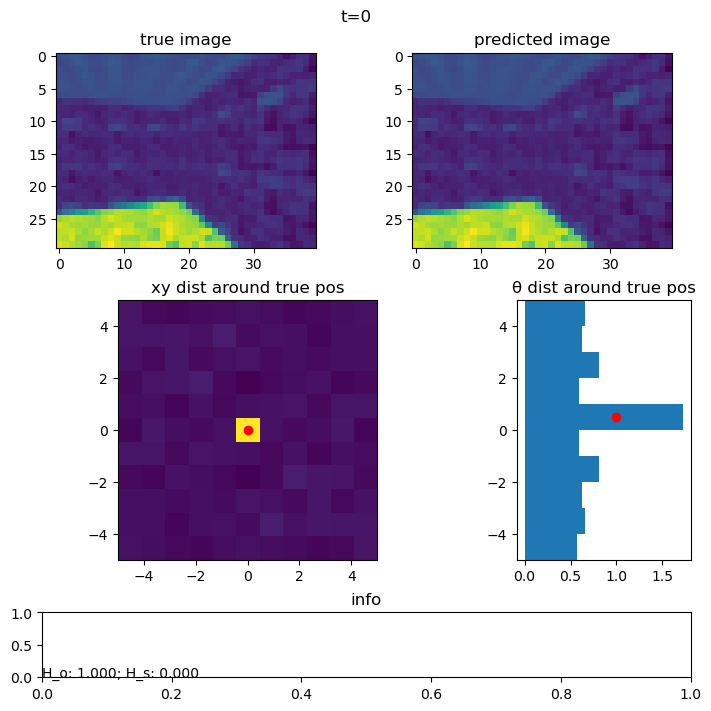

In [3]:
ani  = history[0].make_image_video()
ani.save('test_analytic.gif', progress_callback=lambda x,y: print(f"{x+1}/{y}"))